# CSCN8020 Q Learning Taxi


The environment we define will contain:
- 500 discrete states
- 6 discrete actions
- Reward structure:
    - -1 per step
    - +20 for correct passenger drop-off
    - -10 for illegal pickup or drop-off

The goal is to learn the optimal policy that maximizes cumulative reward by efficiently transporting passengers.

Legend:
- Agent: Taxi
- Enviornment: Taxi-v3 grid world
- State Space: 500 discrete states
- Action Space: 6 discrete actions
- Policy: ε-greedy
- Value function: Q(s,a)
- Learning Type: Model free, off-policy, Temporal difference

The Q-Learning update rule:
Q(s,a) ← Q(s,a) + α [r + γ max_a' Q(s',a') − Q(s,a)]

Where:
- α = learning rate
- γ  = discount factor
- ε =  exploration factor ( ε-greedy policy)



## 1. Import & Setup

In [72]:
from idlelib.rpc import request_queue

import gymnasium as gym
import numpy as np
import random
import logging
import matplotlib.pyplot as plt
import time

# Setup logging
logger = logging.getLogger("TaxiQLearning")
logger.setLevel(logging.INFO)

# Clear old handlers (important in notebooks)
if logger.hasHandlers():
    logger.handlers.clear()

file_handler = logging.FileHandler("taxi_training.log", mode="w")
formatter = logging.Formatter(
    "%(asctime)s | %(levelname)s | %(message)s",
    datefmt="%Y-%m-%d %H:%M:%S"
)
file_handler.setFormatter(formatter)
logger.addHandler(file_handler)

# Simulation logger (separate file)
sim_logger = logging.getLogger("TaxiSimulation")
sim_logger.setLevel(logging.INFO)


if sim_logger.hasHandlers():
    sim_logger.handlers.clear()

sim_file_handler = logging.FileHandler("taxi_simulation.log", mode="w")
sim_file_handler.setFormatter(formatter)
sim_logger.addHandler(sim_file_handler)

log_to_file=False

Imports explanation:
- gymnasium: provides Taxi environment for experiment
- numpy: used for Q-table and math operations
- random: used for epsilon-greedy exploration
- logging: used to store metrics into a file that can be used to analyze and compare info
- matplotlib: used for plotting performance curves

The Q-table will be a 500 x 6 matrix
Each row corresponds to a state while each column corresponds to an action.

## 2. Initialize Environment & Analysis

Observation space: 500 states

State encoding:
((taxi_row * 5 + taxi_col) * 5 + passenger_location) * 4 + destination

Breakdown:
- 25 taxi positions
- 5 passenger locations
- 4 destination locations

Action Space (6 actions):
0: South (Down)
1: North (Up)
2: East (Right)
3: West (Left)
4: Pickup passenger
5: Drop off passenger

Reward Structure:
- -1per step
- +20 successful passenger drop-off
- -10 illegal pickup or drop off

The step penalty encourages shortest-path behavior
The +20 reward propagates backward via bootstrapping which is to say, the agent updates its current state-value estimate based on the estimated value of the previous state. Over multiple episodes the +20 reward is passed backward a step at a time which eventually points directly toward the goal.

In [73]:
env = gym.make("Taxi-v3")

state_size = env.observation_space.n
action_size = env.action_space.n #.n indicates that the environment is using a discrete space and the .n stands for the number and it returns the absolute count of discrete elements within that specific space

print("State Size: ", state_size)
print("Action Size: ", action_size)

State Size:  500
Action Size:  6


## 3. Q-Learning Implementation

We implement tabular Q-Learning:
This means the agent uses a 2D matrix(states as rows, actions as columns) to store expected future rewards, continuously updating these values through experience to learn the best possible action for any given situation

Q-table dimensions
500 x 6

Policy:
ε-greedy

Update:
Q(s,a) += α [ r + γ max Q(s',a') − Q(s,a) ]

The TD error is
δ = r + γ max Q(s',a') − Q(s,a)

If δ > 0 → underestimation
If δ < 0 → overestimation

The algorithm is model-free and off-policy.


In [74]:
def train_q_learning(name, alpha, gamma, epsilon, episodes=5000, log_to_file=False):

    if log_to_file:
        logger.info("="*70)
        logger.info(f"Starting Experiment: {name}")
        logger.info(f"Alpha (Learning Rate): {alpha}")
        logger.info(f"Gamma (Discount Factor): {gamma}")
        logger.info(f"Epsilon (Exploration Rate): {epsilon}")
        logger.info("="*70)

    Q  = np.zeros([state_size, action_size])

    steps_per_episode = []
    rewards_per_episode = []

    for episode in range(episodes):

        state, _ = env.reset()
        done = False
        total_reward = 0
        steps = 0

        while not done:
            #ε-greedy action selection
            if random.uniform(0, 1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])

            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated

            #Q-Update
            Q[state, action] += alpha * (
                reward + gamma * np.max(Q[next_state]) - Q[state, action]
            ) # This line of code adjusts the current q-value byt taking a small step (determined by the learning rate alpha) toward the newly observed reality, which is the immediate reward plus the best possible estimated future value

            state = next_state
            total_reward += reward
            steps += 1

        steps_per_episode.append(steps)
        rewards_per_episode.append(total_reward)


      #Logs training
        if log_to_file and (episode + 1) % 10 == 0:
            logger.info(
                f"Episode {episode+1:4d} | "
                f"Steps: {steps:4d} | "
                f"Reward: {total_reward:6.2f}"
            )


    return Q, steps_per_episode, rewards_per_episode



## 4. Metric Reporting

The following metrics will be reported:
1. Total Episodes
2. Total steps per episode
3. Average return per episode
Each is computed and loged for each experiment

In [75]:
def summarize_results(name, steps, rewards):

    total_episodes = len(rewards)
    avg_return = np.mean(rewards)
    avg_steps = np.mean(steps)

    summary = (       f"\n{'#'*60}\n"
        f"EXPERIMENT: {name}\n"
        f"Total Episodes: {total_episodes}\n"
        f"Average Return: {avg_return:.3f}\n"
        f"Average Steps: {avg_steps:.3f}\n"
        f"{'#'*60}\n"
    )

    print(summary)
    logger.info(summary)





## 5. Base Training run

In [76]:
name = "Base_Run"
alpha = 0.1 #Learning Rate
gamma = 0.9 # Discount Factor
epsilon = 0.1 #Exploration Rate

Q_base, steps_base, rewards_base, = train_q_learning(name, alpha, gamma, epsilon)

summarize_results("Base_Run", steps_base, rewards_base)


############################################################
EXPERIMENT: Base_Run
Total Episodes: 5000
Average Return: -21.888
Average Steps: 30.569
############################################################



## 6. Plot Base Metrics

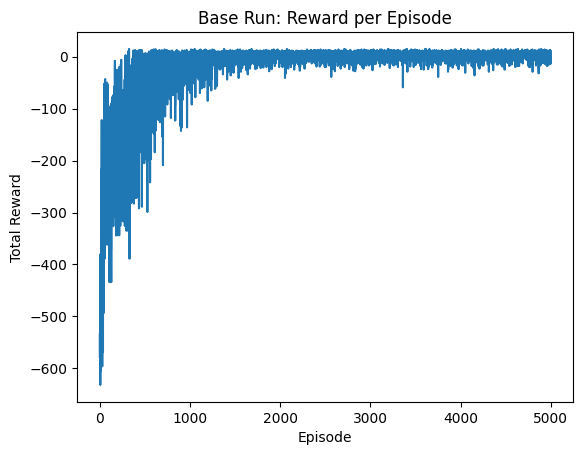

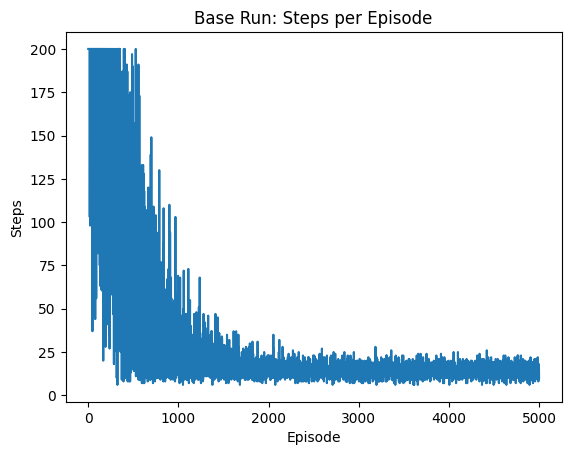

In [58]:
plt.figure()
plt.plot(rewards_base)
plt.title("Base Run: Reward per Episode")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.show()

plt.figure()
plt.plot(steps_base)
plt.title("Base Run: Steps per Episode")
plt.xlabel("Episode")
plt.ylabel("Steps")
plt.show()

These Two plots show us important things to understand how the base run went.
In the first plot it shows the rewards per episode. You can see that in the earlier episodes the rewards are very low deep into the negatives but around  episode 1500 it starts to converge? And  the rewards become 0 or positive

The second plot shows the amount of steps per episode. Like before the agent takes alot of steps at the starts since its exploring. By the 1500 episode mark it takes much less steps attempting to take the minimal and most optimal steps need

## 7. Hyperparameter Analysis & Learning Rate Experiments

Learning Rate α:
Small means slower convergence while Large means its faster for convergence but has unstable updates which is to say, the learning rate dictates how much we trust a single new experience vs the previous accumulated historical knowledge.

When its small the Q-value is only updated by a tiny function of the TD error. When its large the agent just aggressively overwrites the past knowledge with whatever just happened which helps it quickly adapt to new information

Discount Factor  γ:
Low means the agent is short sighted(prioritizes immediate rewards) while high means the agent is far-sighted(Prioritizes long term rewards). When the discount factor is close to 0 the agent becomes myopic which means it heavily discounts anything that doesnt happen immediately.

When its high the agent carries so much about rewards in the far future its almost the same as if it's the very next step. In this taxi experiment where we have set +20 drop off rewards and -1-step penalties, it is necessary to have a high discount factor, or it wouldn't endre the string of the penalties required to reach the reward


In [59]:
learning_rates = [0.01, 0.001, 0.2]

lr_results = {}

for lr in learning_rates:
    Q, steps, rewards = train_q_learning(
        name=f"LR_{lr}",
        alpha=lr,
        gamma=0.9,
        epsilon=0.1,
        log_to_file=False
    )

    summarize_results(f"LR_{lr}", steps, rewards)

    lr_results[lr] = {
        "steps": steps,
        "rewards": rewards,
        "avg_return": np.mean(rewards),
        "avg_steps": np.mean(steps),
    }



############################################################
EXPERIMENT: LR_0.01
Total Episodes: 5000
Average Return: -161.293
Average Steps: 127.594
############################################################


############################################################
EXPERIMENT: LR_0.001
Total Episodes: 5000
Average Return: -258.791
Average Steps: 185.363
############################################################


############################################################
EXPERIMENT: LR_0.2
Total Episodes: 5000
Average Return: -11.164
Average Steps: 23.186
############################################################



## 8. Discount Factor Experiments

In [60]:
discount_factors = [0.2, 0.3]

gamma_results = {}

for g in discount_factors:
     Q, steps, rewards = train_q_learning(
        name=f"GAMMA_{g}",
        alpha=0.1,     # keep alpha fixed
        gamma=g,
        epsilon=0.1,
         log_to_file=False
    )

     summarize_results(f"GAMMA_{g}", steps, rewards)

     gamma_results[g] = {
        "steps": steps,
         "rewards": rewards,
         "avg_return": np.mean(rewards),
         "avg_steps": np.mean(steps),
     }


############################################################
EXPERIMENT: GAMMA_0.2
Total Episodes: 5000
Average Return: -63.151
Average Steps: 62.382
############################################################


############################################################
EXPERIMENT: GAMMA_0.3
Total Episodes: 5000
Average Return: -51.275
Average Steps: 53.430
############################################################



## 9. Comparison Plots for Learning Rates

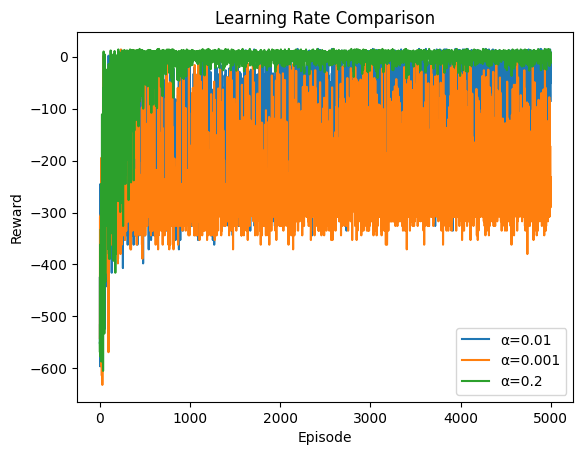

In [61]:
plt.figure()
for lr in lr_results:
    plt.plot(lr_results[lr]["rewards"], label=f"α={lr}")
plt.legend()
plt.title("Learning Rate Comparison")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

## 10. Comparison Plots for Discount Factors

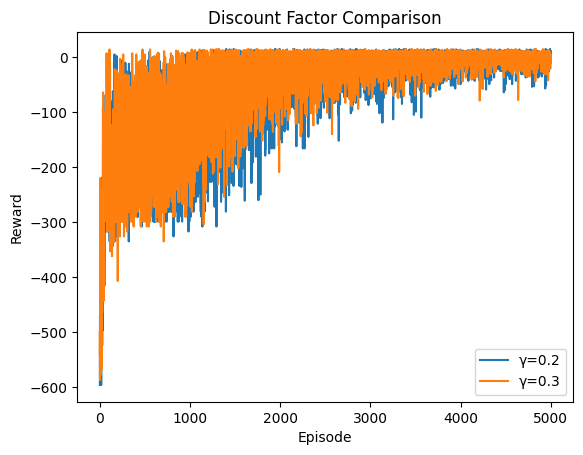

In [62]:
plt.figure()
for g in gamma_results:
    plt.plot(gamma_results[g]["rewards"], label=f"γ={g}")
plt.legend()
plt.title("Discount Factor Comparison")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

## 11. Best combination Selection

Based on:
- Convergence Speed
- Stability
- Average return

The best α & γ are chosen

In [63]:
best_alpha = 0.1 #place holder for right now still shoudl analyze plots more
best_gamma = 0.9

Q_best, steps_best, rewards_best = train_q_learning("Best_Combination", best_alpha, best_gamma, 0.1, log_to_file=True)

summarize_results("BEST_COMBINATION", steps_best, rewards_best)


############################################################
EXPERIMENT: BEST_COMBINATION
Total Episodes: 5000
Average Return: -20.883
Average Steps: 29.829
############################################################



## 12. Compare Base vs Best Plots

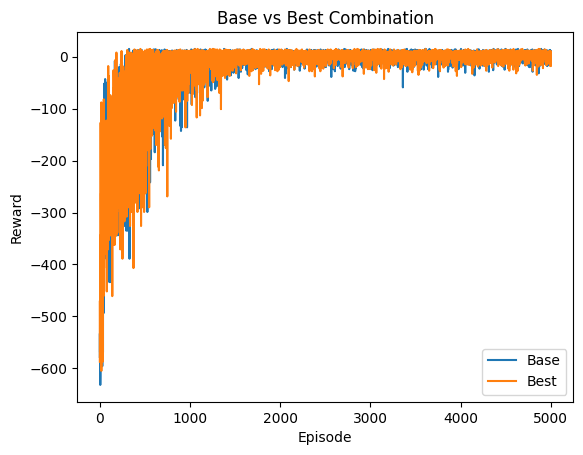

In [64]:
plt.figure()
plt.plot(rewards_base, label="Base")
plt.plot(rewards_best, label="Best")
plt.legend()
plt.title("Base vs Best Combination")
plt.xlabel("Episode")
plt.ylabel("Reward")
plt.show()

## 13. Taxi Grid World Simulation

In [79]:

def play_agent(Q, episodes=50):

    env_render = gym.make("Taxi-v3", render_mode="human", max_episode_steps=None)


    sim_logger.info("\n" + "="*70)
    sim_logger.info("SIMULATION (Trained Greedy Policy)")
    sim_logger.info("="*70)

    for ep in range(episodes):

        state, _ = env_render.reset()
        done = False
        total_reward = 0
        step_count = 0

        sim_logger.info(f"\nEpisode {ep+1} START")

        while not done:
            env_render.render()
            time.sleep(0.3)

            action = np.argmax(Q[state])

            next_state, reward, terminated, truncated, _ = env_render.step(action)
            done = terminated or truncated

            sim_logger.info(
                f"Step {step_count+1:3d} | "
                f"State: {state:3d} | "
                f"Action: {action} | "
                f"Reward: {reward:4.1f}"
            )

            state = next_state
            total_reward += reward
            step_count += 1

        sim_logger.info(
            f"Episode {ep+1} END | "
            f"Total Steps: {step_count} | "
            f"Total Reward: {total_reward:.2f}"
        )

        print(f"Episode {ep+1} | Steps={step_count} | Reward={total_reward}")

    env_render.close()

play_agent(Q_best, episodes=50)

KeyboardInterrupt: 

#### 5.1 Quick Simulation of Fist 10 Episodes of training

In [78]:
def watch_training(alpha=0.1, gamma=0.9, epsilon=0, episodes=5):

    env_watch = gym.make("Taxi-v3", render_mode="human")
    state_size = env_watch.observation_space.n
    action_size = env_watch.action_space.n

    #Start with the empty Q-table
    Q = np.zeros((state_size, action_size))

    for ep in range(episodes):

        state, _ = env_watch.reset()
        done= False
        total_reward = 0
        steps = 0

        print(f"\nEpisode {ep+1}  START")

        while not done:

            env_watch.render()
            time.sleep(0.3)

            # ε-greedy action selection
            if random.uniform(0,1) < epsilon:
                action = env.action_space.sample()
            else:
                action = np.argmax(Q[state])

            next_state, reward, terminated, truncated, _ = env_watch.step(action)
            done = terminated or truncated

            #Q-learning update
            Q[state, action] += alpha * (
                reward + gamma * np.max(Q[next_state]) - Q[state, action]

            )

            state = next_state
            total_reward += reward
            steps += 1

        print(f"Episode {ep+1}  END | Steps={steps} | Reward={total_reward}" )

    env_watch.close()

watch_training(alpha=0.1, gamma=0.9, epsilon=0, episodes=5)


Episode 1  START


KeyboardInterrupt: 